In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import numpy.ma as ma


In [2]:
file = open("/home/andres/repos/rat-mapping-paper/reports/C_SMA_LAR/combine.pkl","rb")
combinations = pickle.load(file)

In [3]:
df = pd.read_csv("/home/andres/data/hbmep-processed/C_SMA_LAR/data.csv")

In [4]:
df['compound_position'].unique().tolist()

['C5M-C5LL',
 '-C5LL',
 'C5M-C5LM',
 '-C5M',
 '-C5LM',
 '-C5L',
 'C5M-C5L',
 'C6LM-C6RR',
 'C5M-C6LL',
 '-C5LM2',
 'C6RM-C6RR',
 'C6M-C6RM',
 '-C6LM',
 'C5LM1-C5L',
 'C6RM-C6R',
 'C5LM2-C5L',
 '-C6LL',
 '-C6L',
 'C6LM-C6RM',
 'C5LM2-C6L',
 '-C6M',
 'C5LM1-C5LL',
 '-C6R',
 '-C5LM1',
 'C5LM2-C6LL',
 '-C6RR',
 'C6LM-C6M',
 'C5LM2-C5LL',
 'C5M-C6L',
 'C5LM2-C5LM1',
 'C5LM2-C5M',
 'C6M-C6RR',
 'C6R-C6RR',
 'C6M-C6R',
 'C5L-C5LL',
 '-C6RM',
 'C6LM-C6R',
 'C6LL-C6L',
 'C7LM-C7RR',
 'C7RM-C7RR',
 'C7M-C7RM',
 '-C7LM',
 'C7RM-C7R',
 'C7LM-C7RM',
 '-C7M',
 '-C7R',
 '-C7RR',
 'C7LM-C7M',
 'C7M-C7RR',
 'C7R-C7RR',
 'C7M-C7R',
 '-C7RM',
 'C7LM-C7R',
 'C6M-C6LL',
 'C5M-C5LM2',
 'C5M-C5LM1',
 'C6L-C6LL',
 'C6M-C6L',
 'C6M-C6LM2',
 'C6LM1-C6LL',
 'C6LM2-C6LM1',
 'C6LM1-C6L',
 'C6M-C6LM1',
 'C6LM2-C6LL',
 '-C6LM2',
 'C6LM2-C6L',
 '-C6LM1',
 'C6LM-C6LL',
 'C6M-C6LM',
 'C6LM-C6L']

In [8]:
subjects = df["participant"].unique().tolist()
sizes = ['S', 'B']
positions = df.compound_position.unique().tolist()
# positions = sorted([p for p in positions if (p.split('-')[0] == "" or p.split('-')[1] == "")])
targets = ['LL','L', 'LM1', 'LM2','LM', 'M']
levels = ['C5', 'C6']
# positions = [p for p in positions if (p.split('-')[1][2] in targets and p.split('-')[1][1] != "7")]
muscles = set([m[3] for m in combinations.keys()])

In [6]:
arr = []
mask = []

for subject in subjects:
    for level in levels:
        for target in targets:
            for size in sizes:
                for muscle in muscles:
                    position = f"-{level}{target}"
                    key = (subject, position, size, muscle)
                    if key in combinations.keys():
                        currenta = combinations[key]['a']
                        currenta = currenta.reshape(-1, 1)
                        arr.append(currenta)
                        mask.append(np.full((4000, 1), False))
                    else:
                        arr.append(np.zeros(4000).reshape(-1, 1))
                        mask.append(np.full((4000, 1), True))

arr = np.array(arr)
arr = arr.reshape(len(subjects), len(levels), len(targets), len(sizes), len(muscles), *arr.shape[1:])
mask = np.array(mask)
mask = mask.reshape(len(subjects), len(levels), len(targets), len(sizes), len(muscles), *mask.shape[1:])

arr = ma.masked_array(arr, mask=mask)
arr = arr[..., 0]


In [9]:
arr.shape #subects, levels, targets, sizes, muscles

(8, 2, 6, 2, 6, 4000)

In [22]:
pvalues = []
data = [] 
means = []
mask = []
labels = []

for a_size_ind, size in enumerate(sizes):
    for a_tar_ind, target in enumerate(targets):
    
        label = f"{size}: -{target}"
        labels.append(label)
        for b_size_ind, s in enumerate(sizes):
            for b_tar_ind, t in enumerate(targets):
            
                
                if a_tar_ind == b_tar_ind and a_size_ind == b_size_ind:
                    pvalues.append(1)
                    mask.append(True)
                    data.append(label)
                    means.append(0)
                    continue
                mask.append(False)

                a = arr[:, :,a_tar_ind, a_size_ind, :] #subject, level, muscle, post samples
                b = arr[:, :,b_tar_ind, b_size_ind, :]
                
                t = a.mean(axis = -1) - b.mean(axis = -1)
                
                ttest = stats.ttest_1samp(t, popmean=0, axis=(0,1,2), alternative = "two-sided")
                pvalues.append(ttest.pvalue)
                ci = ttest.confidence_interval(.95)
                t = a - b
                data.append(
                    f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
                )
                means.append(t.mean())   

pvalues = np.array(pvalues)
pvalues = pvalues.reshape(12,12)   

mask = np.array(mask)
mask = mask.reshape(12,12)

data = np.array(data)
data = data.reshape(12,12)

means = np.array(means)
means = means.reshape(12,12)

labels = [e for e in labels if e not in ['S: -LM', 'B: -LM1','B: -LM2']]

#Mask the data that doesn't exist
m2 = means
check = np.all((np.isnan(m2)) | (m2 == 0), axis=1)
m2 = m2[~check]
data = data[~check]
mask = mask[~check]
pvalues = pvalues[~check]

check = np.all((np.isnan(m2)) | (m2 == 0), axis=0)
m2 = m2[:,~check]
data = data[:,~check]
mask = mask[:,~check]
pvalues = pvalues[:,~check]

/tmp/ipykernel_1491048/921940083.py:34: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  f"{t.mean():.3f}\n({ci.low:.2f}, {ci.high:.2f})"
/tmp/ipykernel_1491048/921940083.py:47: UserWarning: Warning: converting a masked element to nan.
  means = np.array(means)


In [20]:
pvalues.shape

(9, 9)

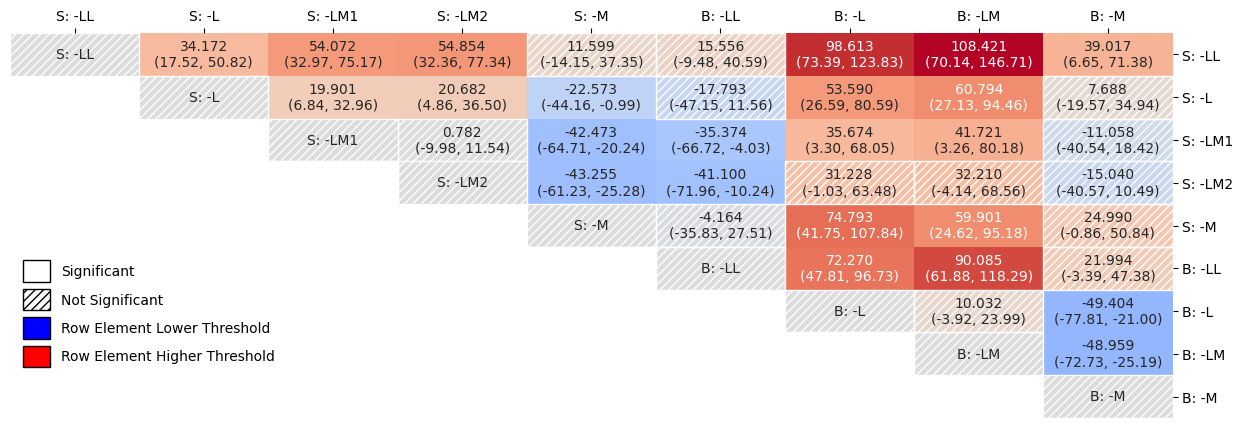

In [23]:
# cbar=True, cbar_kws = dict(use_gridspec=False,location="top", shrink = 0.2)
mask2= mask
mask2 = np.tril(np.ones_like(mask2), k=-1)
mask2 = mask2

plt.figure(figsize=(15, 5))
values = means
handles = []
cmap = 'coolwarm'
ax=sns.heatmap(m2, xticklabels=labels, yticklabels=labels, annot=data, fmt= "", mask =mask2,cbar = False,center = 0, cmap = "coolwarm")
plt.xticks(rotation=45);
hatch_mask = pvalues > 0.05

for i in range (pvalues.shape[0]):
  for j in range(pvalues.shape[1]):
      if hatch_mask[i, j]:
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
        
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower Threshold"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher Threshold"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
          handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()
plt.show()


In [78]:
set([p for p in positions if ((p.split('-')[0] < p.split('-')[1]) and (p.split('-')[0] != "" and p.split('-')[1] != ""))])

{'C5L-C5LL',
 'C5LM2-C5M',
 'C5LM2-C6L',
 'C5LM2-C6LL',
 'C5M-C6L',
 'C5M-C6LL',
 'C6L-C6LL',
 'C6LM-C6M',
 'C6LM-C6R',
 'C6LM-C6RM',
 'C6LM-C6RR',
 'C6M-C6R',
 'C6M-C6RM',
 'C6M-C6RR',
 'C6R-C6RR',
 'C6RM-C6RR',
 'C7LM-C7M',
 'C7LM-C7R',
 'C7LM-C7RM',
 'C7LM-C7RR',
 'C7M-C7R',
 'C7M-C7RM',
 'C7M-C7RR',
 'C7R-C7RR',
 'C7RM-C7RR'}